# Analysis of UQ runs
These notebooks will be used to plot data and data analysis for UQ runs for SOFE 2023.


## Run information

- baseline 2018
- pnetel is 400.
- Fixed rmajor to 9.0, the average of a previous uq run.
- Maximise Net Electric
- pheat turned on
- UQ bounds ~10%

## Import the Uncertainty Data and create object

## Calculate Sensitivity Indices and Reliability

In [1]:
%load_ext autoreload
%autoreload 1
from pathlib import Path
import sys
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, InteractivePlot
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()

proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/total_runs_2/uq_run_05p_correct/"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit)
print("number of converged samples:",len(uq_data.converged_df))



Loading BokehJS ...

number of converged samples: 264


In [2]:
uq_data.calculate_sensitivity(figure_of_merit)
uq_data.calculate_reliability()
# print("rmajor mean: ", round(uq_data.converged_df["rmajor"].mean(),2))
print("Number of samples: ", len(uq_data.uncertainties_df))
print(
    "Number of converged runs: ",
    uq_data.number_of_converged_runs,
)
print("Reliability: ", uq_data.reliability_index)


Number of samples:  25988
Number of converged runs:  264
Reliability:  0.01


## Regional Sensitivity - what causes PROCESS to converge?

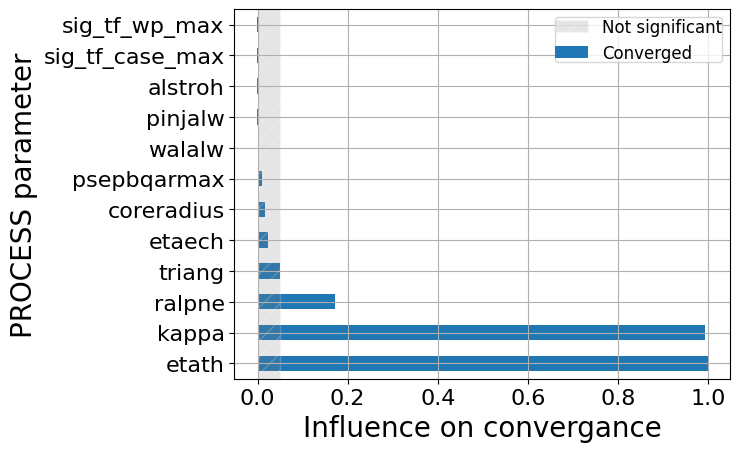

['etath', 'kappa', 'ralpne']


In [3]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.05).tolist()
print(significant_conv_vars)

## Find the iteration variables which are influential for the significant convergence variables

{'num_vars': 264, 'names': ['bt', 'te', 'beta', 'dene', 'tfcth', 'wallmw', 'ohcth', 'bigq', 'bore', 'betalim', 'coheof', 'cohbop', 'fvsbrnni', 'itvar019', 'itvar020', 'jwptf', 'vtfskv', 'vdalw', 'tdmptf', 'thkcas', 'thwcndut', 'fcutfsu', 'cpttf', 'plhthresh', 'tmargtf', 'tmargoh', 'oh_steel_frac', 'pdivt', 'powfmw']}
[[5.2230e+00 1.1750e+01 2.8833e-02 ... 6.3671e-01 1.4073e+02 1.5504e+03]
 [5.2219e+00 1.1917e+01 2.9572e-02 ... 5.9188e-01 1.3348e+02 1.6195e+03]
 [5.2095e+00 1.1851e+01 2.9394e-02 ... 6.2101e-01 1.4315e+02 1.5897e+03]
 ...
 [5.1565e+00 1.1742e+01 2.9859e-02 ... 6.0550e-01 1.4810e+02 1.6343e+03]
 [5.2208e+00 1.1641e+01 2.8645e-02 ... 6.3182e-01 1.5035e+02 1.5463e+03]
 [5.2222e+00 1.1715e+01 2.8925e-02 ... 6.2892e-01 1.6012e+02 1.5629e+03]]
[0.41192 0.4004  0.40027 0.39698 0.39985 0.39809 0.41157 0.43084 0.41964
 0.40889 0.41104 0.43779 0.41996 0.39382 0.40916 0.3886  0.41831 0.40125
 0.39354 0.39619 0.41329 0.42243 0.40294 0.38835 0.38881 0.40825 0.3825
 0.40133 0.41611 0.

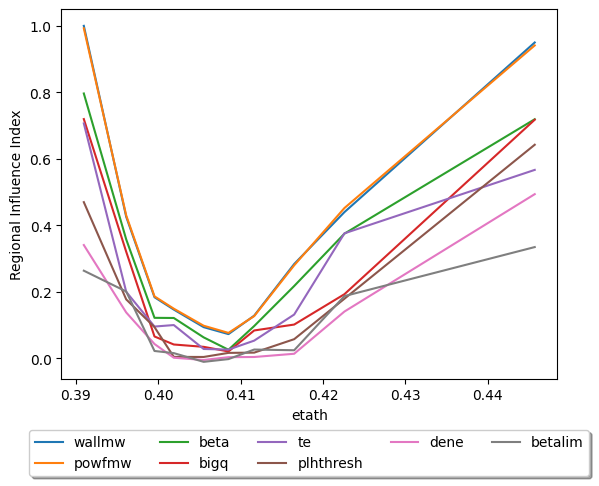

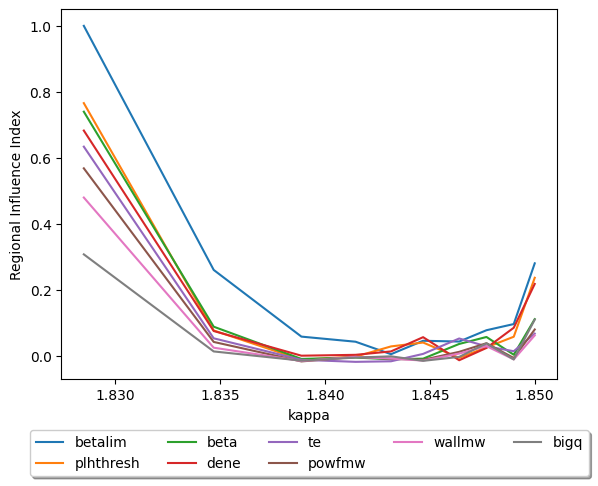

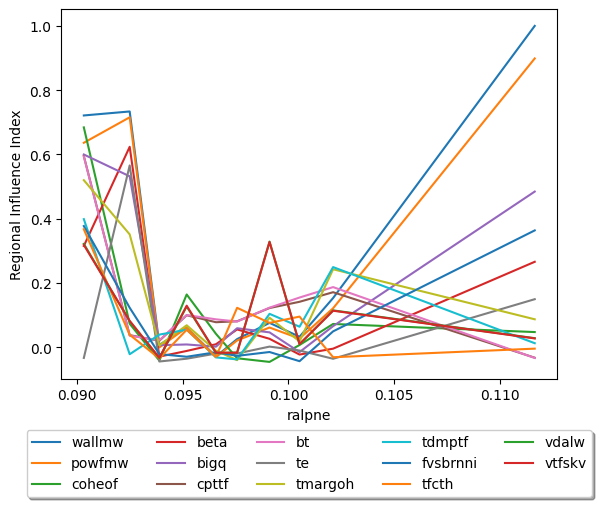

In [4]:
rsa_variables = uq_data.itv
significant_itv_list = []
for item in significant_conv_vars:
    rsa_df = uq_data.regional_sensitivity_analysis(figure_of_merit=item,variables_to_sample=rsa_variables, dataframe=uq_data.converged_df, bins=10, confidence_level = 0.30)
    significant_itv_list.extend(rsa_df.index.tolist())
significant_itv_list = list(dict.fromkeys(significant_itv_list))
print("These iteration values drive performance recovery:", significant_itv_list)

## Create a copula based on the important variables for convergence and iteration variables

In [5]:
copula = Copula(uq_data.converged_df, significant_conv_vars)
copula.calculate_copula(input_sample_size=50,synthetic_sample_size=100000)
copula.calculate_pdf()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


etath     0.405301
kappa     1.841939
ralpne    0.095916
pdf       0.078480
Name: 36766, dtype: float64

In [6]:
itv_vars = significant_conv_vars + significant_itv_list
print(significant_itv_list)
itv_copula = Copula(uq_data.converged_df,itv_vars)
itv_copula.calculate_copula(input_sample_size=200,synthetic_sample_size=100000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()



['wallmw', 'powfmw', 'beta', 'bigq', 'te', 'plhthresh', 'dene', 'betalim', 'coheof', 'cpttf', 'bt', 'tmargoh', 'tdmptf', 'fvsbrnni', 'tfcth', 'vdalw', 'vtfskv']


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [7]:
# custom_data = {"kappa":2.14,"etath":0.41}
sens_plots=InteractivePlot(uq_data,copula,num_intervals=20)#custom_data_point=custom_data)
sens_plots.create_graph_grid(significant_conv_vars)
sens_plots.create_datatable(significant_conv_vars)

Custom Point is non-convergent


In [8]:
custom_data={"kappa":1.90,"etath":0.38,"ralpne":0.10}
itv_plots=InteractivePlot(uq_data,itv_copula,num_intervals=20,custom_data_point=custom_data)
itv_plots.create_layout(itv_vars,plot_graph=False)

KeyError: 20